In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes
import glob
from astropy.table import Table
from astropy.table import join
from astropy.table import vstack
import pandas as pd
import pdb
from tqdm import tqdm

# Creating Contrast Curves

This notebook allows for the creation of contrast curves for the James Webb Space Telescope NIRCAM, first by simply making a raw contrast measurement, then by estimating and calibrating coronagraphic and algorithmic throughput and remeasuring the contrast. 

## The Raw Contrast Curve
### Loading the dataset

In this tutorial, we will utilize the telescope's two roll angles as well as a library of reference images in order to perform and evaluate both angular differential imaging (ADI) and reference differential imaging (RDI). Since we'll need to generate lots of datasets throughout this tutorial, we'll define dataset generation as a function. This function should load the roll angles (10° is the max) and the reference library where necessary, as well as the center of the image and the inner working angle in order to create a full sequence of images. 

**Before doing this, be sure to specify the directory your data is contained in, your preferred filter, and the mode (ADI or RDI) that you'd like to use this tutorial for.**

In [2]:
# # Let's specifiy the important variables first. Change this as needed.
# mode = "ADI" 
# datadir = "old_simulated_data/"
# filtername = "f444w"
# pas_list = [0, 10]
# rollnames_list = ["roll1", "roll2"]
# unocculted_psf = "NIRCam_unocculted_f300m.fits"
# center_x = 71 # Center (x) of the unocculted psf
# center_y = 30 # Center (y) of the unocculted psf
# OWA = 45 # Set this to be what you want your outermost contrast curve separation to be

# # Mask for real planets
# mask = "on"
# x_positions= [41,43]
# y_positions= [54,70]

# #Read in transmission profile of coronagraph used
# coronagraph = pd.read_csv("MASK210R.csv", names = ["rad_dist", "trans"])

# # Make lists of filenames
# filenames_list =  ["NIRCam_target_Roll1_f300m.fits", "NIRCam_target_Roll2_f300m.fits"]


In [3]:
# Let's specifiy the important variables first. Change this as needed.

mode = "ADI" 
datadir = "Eps_Eri_Sim/"
filtername = "f300m"
pas_list = [0, 10, 3.3, 6.7]
rollnames_list = ["roll1", "roll2", "roll3", "roll4"]
unocculted_psf = "offaxistarget.fits"
OWA = 45 # Set this to be what you want your outermost contrast curve separation to be
center_x = 67 # Center (x) of the unocculted psf
center_y = 67 # Center (y) of the unocculted psf

# Mask for real planets
mask = "off"
x_positions= None
y_positions= None

#Read in transmission profile of coronagraph used
coronagraph = pd.read_csv("MASK430R.csv", names = ["rad_dist", "trans"])

# Make lists of filenames
filenames_list =  ["Target/TargetCube.fits"]

In [4]:
def generate_datasets(datadir, filenames_list, rollnames_list, pas_list, num_datasets=1, mode = 'ADI'):
    """
    Generates multiple generic datasets based on the two JWST roll angles 0° and 10°
    
    Args:
        datadir (str): The directory the data is contained in
        filenames (list: str): A list of the names of all the files you'd like to read in
        rollnames (list: str): A list of the names you'd like to call your roll angles
        pas_list (list: float): A list of all the position/roll angles of your data
        num_datasets(int): Number of datasets to be generated. Default is 1.
        data_type (str): The type of data reduction you'd like to generate data for (adi or rdi). adi is default
    
    Returns:
        list: List of generated datasets
        list: psf library
    """
    if mode not in ('ADI','RDI'):
        raise ValueError(f"Uknown data type {mode}")
    
    # Use this function if mode is adi
    def _process_adi(datadir, filenames_list, rollnames_list, pas_list, num_datasets=1):
        datasets = []
        psflibs = []
        for dataset in range(num_datasets):
            
            # Read in your data
            data = [fits.getdata(f"{datadir}{filename}") for filename in filenames_list]
            
              
            # Combine your data if you read in multiple roll angles (if you read in the full cube already, this function will still work and just return your cube)
            full_seq = np.concatenate(data, axis=0)

            # Create an array of all the roll angles. First check to see if each image has 1 or more frames 
            
            if full_seq.shape[0] > len(pas_list):
                for d in data:
                    pas = np.ravel([[pa]*d.shape[0] for pa in pas_list])
                    
            elif full_seq.shape[0] == len(pas_list):
                pas = np.array(pas_list)

            # For each image, the (x,y) center where the star is is just the center of the image
            centers = np.array([np.array(frame.shape) // 2.0 for frame in full_seq])
            
            # Give each roll angle a name so we can refer to them.  First check to see if each image has 1 or more frames 
            if full_seq.shape[0] > len(rollnames_list):
                rollnames = []
                for rn in rollnames_list:
                    rollnames += [f"{rn}_{d}" for d in range(data[0].shape[0])]
                    
            elif full_seq.shape[0] == len(rollnames_list):
                rollnames = rollnames_list

            # Define dataset
            dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=rollnames)
            
            dataset.flipx = False
            
            # Set OWA
            dataset.OWA = round((dataset.input.shape[-1])/2)
            
            psflib = None
            if num_datasets > 1:
                datasets.append(dataset)
                psflibs.append(psflib)
            else:
                datasets = dataset
                psflibs = psflib
        return datasets, psflibs
    
    # Use this function if mode is rdi
    def _process_rdi(num_datasets):
        datasets = []
        psflibs = []
        for dataset in range(num_datasets):
            # read in ref star
            with fits.open(f"{datadir}/NIRCam_refs_SGD_{filtername}.fits") as hdulist:
                ref_cube = hdulist[0].data
            # Read in roll 1
            with fits.open(f"{datadir}/NIRCam_target_Roll1_{filtername}.fits") as hdulist:
                roll1_cube = hdulist[0].data
            # Read in roll 2
            with fits.open(f"{datadir}/NIRCam_target_Roll2_{filtername}.fits") as hdulist:
                roll2_cube = hdulist[0].data
                
            # Combine the two rows
            full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

            # Two rolls are offset 10 degrees
            pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

            # For each image, the (x,y) center where the star is is just the center of the image
            centers = np.array([np.array(frame.shape) // 2.0 for frame in full_seq])

            # Give it some names, just in case we want to refer to them
            filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

            # Create the GenericData object. This will standardize the data for pyKLIP
            dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
            dataset.flipx = False # get the right handedness of the data

            # Combine both science target and reference target images into a psf library array
            psflib_imgs = np.append(ref_cube, full_seq, axis=0)

            ref_filenames = ["ref_{0}".format(i) for i in range(ref_cube.shape[0])]
            psflib_filenames = np.append(ref_filenames, filenames, axis=0)
            
            # All frames aligned to image center (Which are the same size)
            ref_center = np.array(ref_cube[0].shape)/2

            # make the PSF library
            # we need to compute the correlation matrix of all images vs each other since we haven't computed it before
            psflib = rdi.PSFLibrary(psflib_imgs, ref_center, psflib_filenames, compute_correlation=True)

            if num_datasets > 1:
                datasets.append(dataset)
                psflibs.append(psflib)
            else:
                datasets = dataset
                psflibs = psflib
                
        return datasets, psflibs
    
    return _process_adi(datadir, filenames_list, rollnames_list, pas_list, num_datasets) if mode == 'ADI' else _process_rdi(num_datasets) if mode == 'RDI' else None


### Run Klip

Next, we need to remove the starlight from our images in order to accurately measure contrast. We will break the image into 9 concentric annuli, and each annuli into 4 azimuthal sectors, then run KLIP on each of these sectors. Note that when we're in RDI mode, we need to perform an extra step of preparing the psf library.

In [5]:
# Specifying KLIP params. Change as desired
outputdir = "./"
fileprefix = f"pyklip-{filtername}-{mode}-k50a9s4m1"
annuli = 9
subsections = 4
movement = 1

# Generate dataset for use
dataset, psflib = generate_datasets(datadir, filenames_list = filenames_list, rollnames_list = rollnames_list, pas_list = pas_list, mode = mode)


if mode == 'RDI':
    psflib.prepare_library(dataset)
    
# Run pyKLIP RDI
parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=fileprefix, annuli=annuli, 
                      subsections=subsections, numbasis=[1,5,10,20,50], movement = movement, 
                          mode=mode, psf_library=psflib)

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
Closing threadpool


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Derotating Images...
Writing Images to directory /Users/jeaadams/JWST-ERS-Pipeline/notebooks
wavelength collapsing reduced data of shape (b, N, wv, y, x):(5, 4, 1, 101, 101)


### Read the KLIP-ed dataset back in

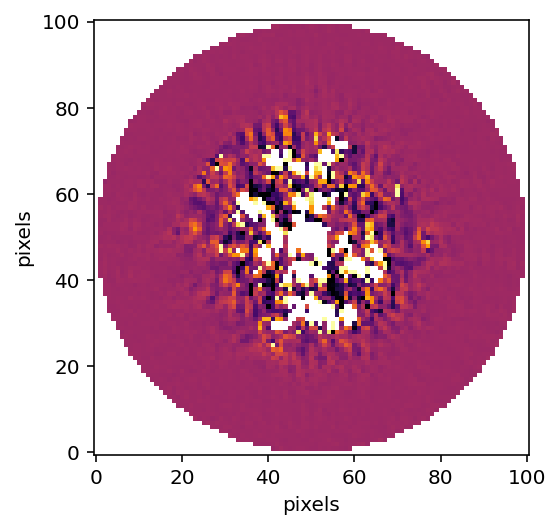

In [6]:
# Read in the KLIP-ed dataset
filesuffix = "-KLmodes-all.fits"

with fits.open(f"{fileprefix}{filesuffix}") as hdulist:
    reduced_cube = hdulist[0].data
    reduced_centers = [hdulist[0].header["PSFCENTX"], hdulist[0].header["PSFCENTY"]]

# Plot the KL10 Cube (index of 2)
plt.imshow(reduced_cube[2], interpolation="nearest", cmap="inferno", vmin = np.nanpercentile(reduced_cube[2], 1), vmax  = np.nanpercentile(reduced_cube[2], 99))
plt.xlabel("pixels")
plt.ylabel("pixels")
plt.gca().invert_yaxis()
plt.show()

### Mask Any Real Planets in Image

At this point, we'd mask any 'real' planets that we know are in the data with nans. You can skip this step if your simulated data has no known planets by setting mask to be "off".

In [7]:
def masking(mask = "off", x_positions = None, y_positions = None, psf_fwhm = 6):
    """
    This function masks any real planets in your data given their x and y positions.
    
    Args:
        mask (str): Keyword to specify whether or not you have any planets you'd like to mask
        x_positions (int): x positions of planets to be masked
        y_positions (int): x positions of planets to be masked (must be in same order as x)
    """
    if mask == 'on':
        
        # Plot the KL10 Cube (index of 2)
        fig = plt.figure(figsize=(10, 3))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(reduced_cube[2], interpolation="nearest", cmap="inferno", vmin=0, vmax=5)
        
        # Place green circles around the real planets
        for j in range(len(x_positions)):
            circle = plt.Circle((x_positions[j], y_positions[j]), 4, fill=False, edgecolor="green", ls="-", linewidth=3)
            ax1.add_artist(circle)
        plt.gca().invert_yaxis()
        ax1.set_xlabel("pixels")
        ax1.set_ylabel("pixels")
        ax1.set_title("PSF Subtracted Image")
        
        # Create an array with the indices are that of KL mode frame with index 2
        ydat, xdat = np.indices(reduced_cube[2].shape)
        
        # Mask the first planet
        for x, y in zip(x_positions, y_positions):
            
            # Create an array with the indices are that of KL mode frame with index 2
            distance_from_star = np.sqrt((xdat - x) ** 2 + (ydat - y) ** 2)
            
            # Mask
            reduced_cube[2][np.where(distance_from_star <= 2 * psf_fwhm)] = np.nan
            
            post_mask_cube = reduced_cube[2]
        
        # Plot the new masked data
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.imshow(post_mask_cube, interpolation="nearest", cmap="inferno", vmin = 0, vmax = 10)
        plt.gca().invert_yaxis()
        ax2.set_xlabel("pixels")
        ax2.set_ylabel("pixels")
        ax2.set_title("Real Planets Masked")
        
    elif mask == 'off':
        post_mask_cube = reduced_cube[2]
        
    return post_mask_cube

### Measure the Contrast

Using the pyKLIP function meas_contrast, we can now compute the 5 $\sigma$ noise at each separation in our image. For this function, we again need to specify our planet's FWHM as well as our outer working angle and the center of our input frame. 

In [8]:
psf_fwhm = 6
masked_cube = masking(mask = mask, x_positions=x_positions, y_positions=y_positions, psf_fwhm = psf_fwhm)

# Measuring the contrast in the image
contrast_seps, contrast = pyklip.klip.meas_contrast(dat=masked_cube, iwa=12, owa=40, resolution=(psf_fwhm), center=reduced_centers, low_pass_filter=False)


### Normalize the contrast measurement

Once the contrast levels are measured, we can normalize it by dividing by the unocculted stellar psf flux. In order to do this, we need to read in and measure the flux of the unocculted psf.

In [9]:
# Read in unocculted PSF
with fits.open(f"{datadir}/{unocculted_psf}") as hdulist:
    psf_cube = hdulist[0].data
    psf_head = hdulist[0].header

if len(psf_cube.shape) == 2:
    psf_frame = psf_cube

elif len(psf_cube.shape) == 3:
    # Collapse reference psf in time
    psf_frame = np.nanmean(psf_cube, axis = 0)

# Find the centroid
bestfit = fakes.gaussfit2d(psf_frame, center_x , center_y, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]
peak_flux = bestfit[0]

# Recenter PSF to that location
x, y = np.meshgrid(np.arange(-20, 20.1, 1), np.arange(-20, 20.1, 1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y, x])


norm_contrast = contrast / peak_flux

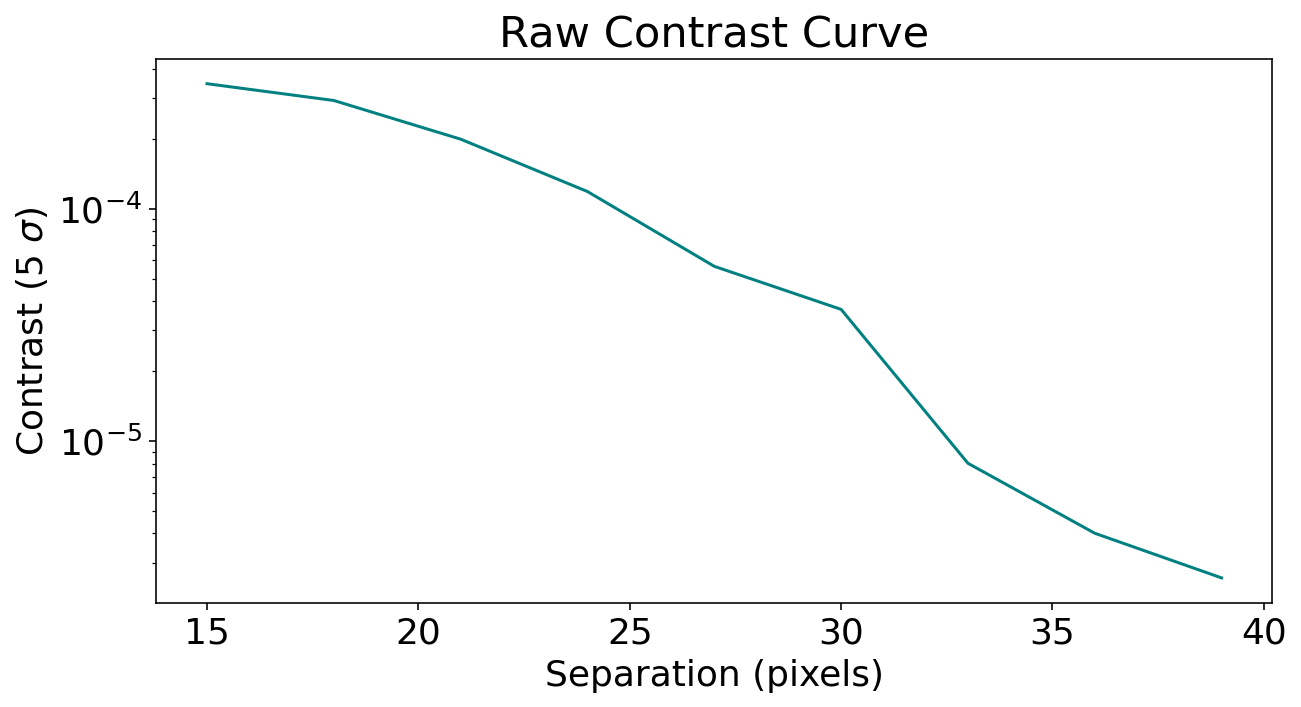

In [10]:
# Plot contrast curve!
plt.rcParams.update({"font.size": 18})
plt.figure(figsize=(10, 5))
plt.plot(contrast_seps, norm_contrast, color="teal")
plt.xlabel("Separation (pixels)")
plt.ylabel("Contrast (5 $\sigma$)")
plt.yscale("log")
plt.title("Raw Contrast Curve")
plt.show()

## Calibrating Throughput

We expect the KLIP reduction process to lead to a decrease in measured planet flux due to over-subtraction and self-subtraction. Now that we've created a raw contrast curve, we can calculate the algorithm throughput of our KLIP reduced images and estimate how much the reduction affects our measurements. 

In order to optimize this calculation, we need to inject multiple fake planets at varying separations and postion angles to get a feel for how throughput changes across the image.

### Correcting for coronagraphic throughput

In addition to the algorithm throughput, we can also account for the effect of JWST's coronograph on light transmission as we inject fake planets. The ``fakes.inject_planet`` function has an optional argument 'field_dependent_correction' which accepts a user provided function to correct for coronagraphic throughput. The signature of the user provided function is (input_stamp: numpy.ndarray, input_dx: numpy.ndarray, input_dy: numpy.ndarray) -> numpy.ndarray. All the numpy arrays in the signature should be 2D. As an example of how this would be done, we'll use the transmission profile of the MASK210 coronagraph (obtained from the Occulting Masks section of this NIRCAM webpage: https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-coronagraphic-occulting-masks-and-lyot-stops).

In [11]:
# First we need to regenerate raw data since the first dataset was KLIP reduced. 
dataset2, psflib2 = generate_datasets(datadir, filenames_list = filenames_list, rollnames_list = rollnames_list, pas_list = pas_list, mode = mode)

if mode == 'RDI':
    psflib2.prepare_library(dataset2)


# Create the throughput correction function
def transmission_corrected(input_stamp, input_dx, input_dy):

    """
    Args:
        input_stamp (array): 2D array of the region surrounding the fake planet injection site
        input_dx (array): 2D array specifying the x distance of each stamp pixel from the center
        input_dy (array): 2D array specifying the y distance of each stamp pixel from the center
        
    Returns:
        output_stamp (array): 2D array of the throughput corrected planet injection site.
        """

    # Calculate the distance of each pixel in the input stamp from the center
    distance_from_center = np.sqrt((input_dx) ** 2 + (input_dy) ** 2)

    # Interpolate to find the transmission value for each pixel in the input stamp (we need to turn the columns into arrays so np.interp can accept them)
    distance = np.array(coronagraph["rad_dist"])
    transmission = np.array(coronagraph["trans"])
    trans_at_dist = np.interp(distance_from_center, distance, transmission)

    # Reshape the interpolated array to have the same dimensions as the input stamp
    transmission_stamp = trans_at_dist.reshape(input_stamp.shape)

    # Make the throughput correction
    output_stamp = transmission_stamp * input_stamp

    return output_stamp

### Injecting the fake planets

The injected fake planets will be scaled down versions of the unocculted PSF. We can choose how many we'd like to put into our dataset, what we want their relative fluxes to be, and their separations from the planet. For now, we'll inject eight planets into a single dataset and we'll use our 5 sigma contrast curve to decided on the contrast values to use.

*Note that the image is only 100 pixels in diameter, and if we factor in the size of a fake planet, our maximum injection separation is limited to ~40 pixels from the center.* 

In [12]:
# Let's choose our contrasts so that they are 500% of the contrast limit
psf_stamp_input = np.array([psf_stamp for j in range(12)])
planet_seps = [12, 15, 20, 24, 28, 32, 36, 40]
input_contrasts = (np.interp(planet_seps, contrast_seps, norm_contrast))*5
pas = 270 - (np.array([0, 40, 80, 120, 160, 200, 240, 280]))

# Now injecting the fake planets in a spiral:
for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas):
    planet_fluxes = psf_stamp_input * input_contrast
    fakes.inject_planet(frames=dataset2.input, centers=dataset2.centers, inputflux=planet_fluxes, astr_hdrs=dataset2.wcs, radius=planet_sep, pa=pa, field_dependent_correction=transmission_corrected)

### Run KLIP - Recover Planets

Now that we've injected our fake planets, we can check how well we were able to recover them by running KLIP. We'll use 4 subsections and 9 annuli as before. Post-klip, we can see the injected planets circled in white, while the 'real' planets are circled in blue. 

**We need to create an empty 'contrastcurves' directory prior to this step**

In [13]:
mkdir contrastcurves

mkdir: contrastcurves: File exists


In [14]:
# Set output directory
outputdir = "contrastcurves"
fileprefix = f"FAKE_KLIP_{mode}_A9K5S4M1"
numbasis = [1, 5, 10, 20, 50]
annuli = 9
subsections = 4
movement = 1

# Run KLIP on dataset with injected fakes
parallelized.klip_dataset(dataset2, outputdir=outputdir, fileprefix=fileprefix, algo="klip", annuli=annuli, subsections=subsections, movement=movement, numbasis=numbasis, mode=mode, psf_library=psflib2)

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
Closing threadpool


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Derotating Images...
Writing Images to directory /Users/jeaadams/JWST-ERS-Pipeline/notebooks/contrastcurves
wavelength collapsing reduced data of shape (b, N, wv, y, x):(5, 4, 1, 101, 101)


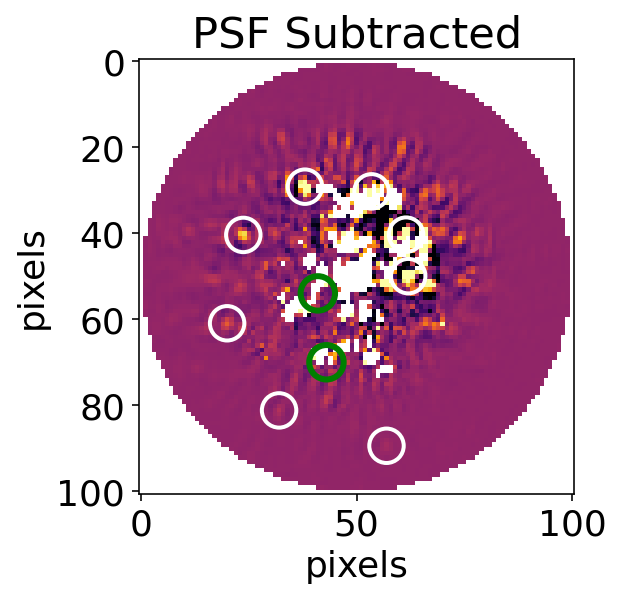

In [15]:
# Plot this reduced data cube.
with fits.open(f"{outputdir}/{fileprefix}{filesuffix}") as hdulist:
    reduced_cube = hdulist[0].data

# Plot the KL10 Cube (index of 2)
fig = plt.figure()
ax = plt.subplot()
ax.set_xlabel("pixels")
ax.set_ylabel("pixels")
ax.set_title("PSF Subtracted")
plt.gca().invert_yaxis()
ax.imshow(reduced_cube[2], interpolation="nearest", cmap="inferno", vmin = np.nanpercentile(reduced_cube[2], 1), vmax = np.nanpercentile(reduced_cube[2], 99))

# Find the positions of the injected planets
injected_x = [50 + sep * np.cos((np.radians(pa + 90))) for sep, pa in zip(planet_seps, pas)]
injected_y = [50 + sep * np.sin((np.radians(pa + 90))) for sep, pa in zip(planet_seps, pas)]

# Find the positions of the 'real' planets
real_x = [41, 43]
real_y = [54, 70]

# Place circles around the injected planets
for i in range(len(injected_x)):
    circle1 = plt.Circle((injected_x[i], injected_y[i]), 4, fill=False, edgecolor="white", ls="-", linewidth=2)
    ax.add_artist(circle1)

# Place green circles around the real planets
for j in range(len(real_x)):
    circle2 = plt.Circle((real_x[j], real_y[j]), 4, fill=False, edgecolor="green", ls="-", linewidth=3)
    ax.add_artist(circle2)

plt.show()

### Recovering Flux Values

We can now visually inspect how well we were able to recover each injected planet. In order to quantify this algrorithm throughput, pyKLIP has a built in function ``retrieve_planet_flux`` that lets us compare the retrieved flux to the input flux.

In [16]:
# Obtain the centers of the output KLIP fits file
with fits.open(f"{outputdir}/{fileprefix}{filesuffix}") as hdulist:
    cube = hdulist[0].data[1]
    cube_centers = [hdulist[0].header["PSFCENTX"], hdulist[0].header["PSFCENTY"]]

# Create and empty list to store retrieved flux values
retrieved_fluxes = []

# Retrieve planet fluxes
for input_contrast, planet_sep, pa in zip(input_contrasts, planet_seps, pas):
    fake_planet_fluxes = []
    fake_flux = fakes.retrieve_planet_flux(frames=cube, centers=cube_centers, astr_hdrs=dataset2.output_wcs[0], sep=planet_sep, pa=pa)
    retrieved_fluxes.append(fake_flux)
    
    

### Calculating throughput

Now that we've run a full reduction on the data with injected planets, we can calculate the throughput to figure our how well we were able to recover the planet at different separations. Throughput can be calculated as follows: throughput = $\frac{output\ flux}{input\ flux}$ at each separation. 

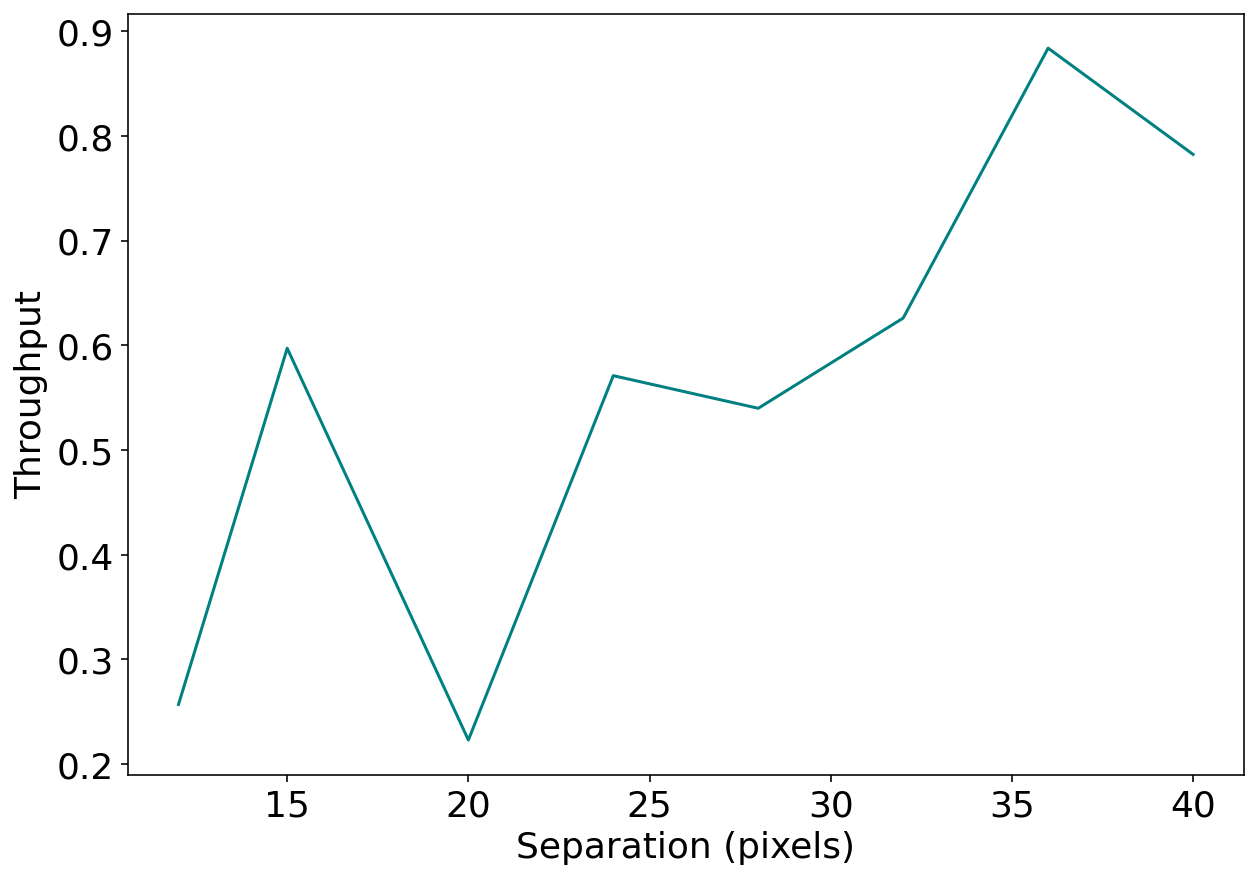

In [17]:
# Calculate the input flux
input_flux = [contrast * peak_flux for contrast in input_contrasts]

# Calculate the throughput
throughput = [retrieved_flux / input_flux for retrieved_flux, input_flux in zip(retrieved_fluxes, input_flux)]
# Now we can visualize our throughput as a function of separation
fig = plt.figure(figsize=(10, 7))
plt.plot(planet_seps, throughput, color="teal")
plt.xlabel("Separation (pixels)")
plt.ylabel("Throughput")
plt.show()

## The Throughput Corrected Contrast Curve

Now that we've calculated the throughput at various separations, we can scale our raw contrast measurements to make them more representative of what we can actually retrieve with KLIP.  

In [18]:
# Normalize the noise contrast by the measured throughput level at that separation
corrected_contrast = [contrast / tp for contrast, tp in zip(norm_contrast, throughput)]

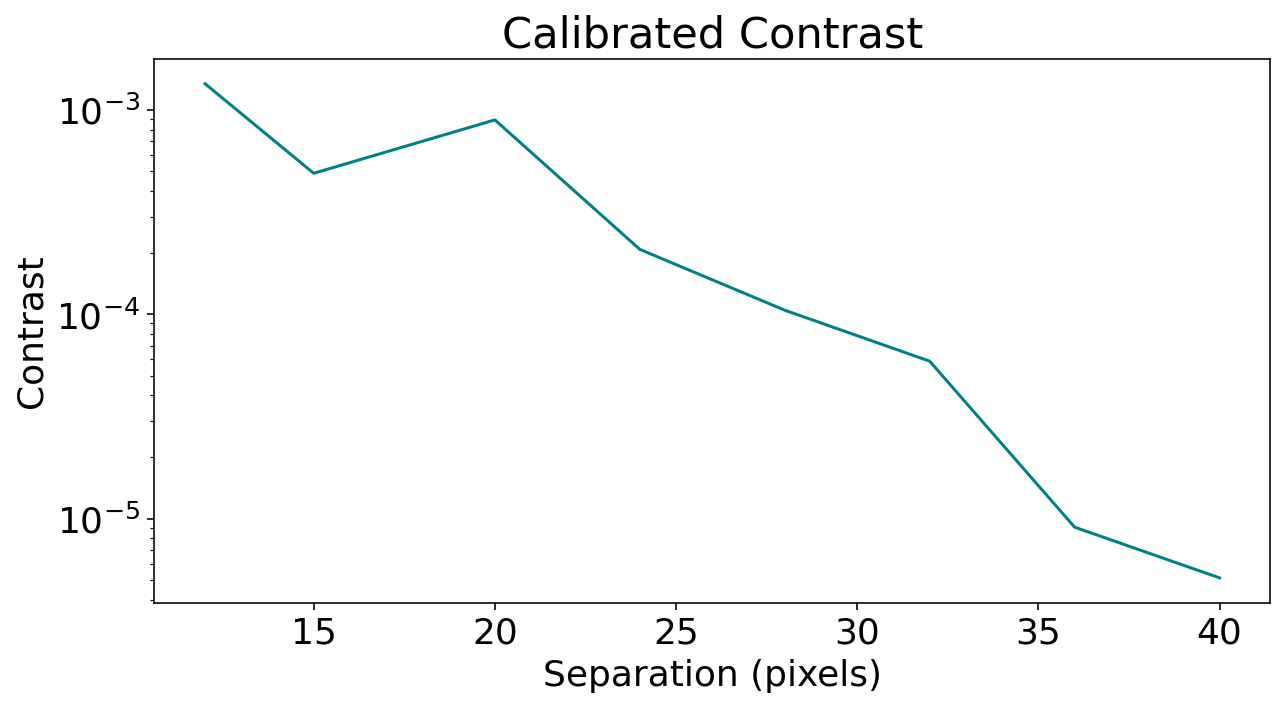

In [19]:
fig = plt.figure(figsize=(10, 5))
plt.plot(planet_seps, corrected_contrast, color="teal")
plt.title("Calibrated Contrast")
plt.ylabel("Contrast")
plt.xlabel("Separation (pixels)")
plt.yscale("log")
plt.show()

## Inject Many More Planets

While the process outlined above will reliably provide us with a throughput corrected contrast curve, we can optimize these contrast measurements by injecting and recovering many more fake planets. However, instead of injecting them all in one go, we will use a loop to inject only a small portion (around 6) into a single dataset at a time. This helps avoid the effects of overcrowding the image, which can lead to us 'losing' planets.

First, we'll define a function that injects and recovers planets, essentially automating the process above. 

### A function to automate fake planet injection, retrieval and measurement

In [22]:
def multiple_planet_injection(datadir, filtername, seps, input_pas, num_datasets, input_contrasts, mode):
    
    """
    Injects multiple fake planets across multiple datasets.

    Args:
        datadir (str): The name of the directory that the data is contained in
        filtername (str) The name of the filter to be used
        seps (list: int): List of separations each planet should be injected at
        input_pas (list: int): List of position angles to inject fake planets at 
        num_datastes(int): The number of datasets to be generated. This is equal to the number of interations of planet injection/number of position angle changes
        input_contrasts(list: float): List of contrasts planets should be injected at
    Returns:
        retrieved_fluxes_all (list): All retrieved planet fluxes
        pas_all (list): All position angles used for injection
        planet_seps_all (list): All planet separations used for injection
        input_contrasts_all (list): All planet contrasts used for injection
    """
    
    pas_all = []
    retrieved_fluxes_all = []
    planet_seps_all = []
    input_contrasts_all = []
    
    # Generate desired number of datasets: number of loops at each separation
    datasets, psflibs = generate_datasets(datadir, filenames_list = filenames_list, rollnames_list = rollnames_list, pas_list = pas_list, mode = mode, num_datasets = num_datasets)

    # Begin fake planet injection and retrieval, changing position angle each time
    for dataset_num, dataset, psflib in zip(range(len(datasets)), datasets, psflibs):
        if mode == 'RDI':
            psflib.prepare_library(dataset)

        # Create stamps of the point spread function to be injected as a fake planet
        psf_stamp_input = np.array([psf_stamp for j in range(12)])
        
        # Clock the position angles of the injected planets by 40 each time
        input_pas = [x+40*dataset_num for x in input_pas]

        start_over = False

        # Inject fake planets
        for input_contrast, sep, pa in zip(input_contrasts, seps, input_pas):

            # Check the distance between the planet to be injected and the real planets. We don't want to inject fake planets too close to the two planets already in the data.
            if x_positions is not None:
                check_sep_x = sep * np.cos((pa + 90))
                check_sep_y = sep * np.sin((pa + 90))
                dist_p1 = np.sqrt((check_sep_x - x_positions[0])**2 + (check_sep_y - y_positions[0])**2)
                dist_p2 = np.sqrt((check_sep_x - x_positions[1])**2 + (check_sep_y - y_positions[1])**2)

                # Make sure fake planets won't be injected within a 12 pixel radius of the real planets
                if dist_p1 > 12 and dist_p2 > 12:

                    planet_fluxes = psf_stamp_input * input_contrast
                    fakes.inject_planet(frames=dataset.input, centers=dataset.centers, inputflux=planet_fluxes, astr_hdrs=dataset.wcs, radius=sep, pa=pa, field_dependent_correction=transmission_corrected)

                # If the fake planet to be injected is within a 12 pixel radius of the real planets, start the loop over
                else:
                    start_over = True
                
            elif x_positions is None:
                planet_fluxes = psf_stamp_input * input_contrast
                fakes.inject_planet(frames=dataset.input, centers=dataset.centers, inputflux=planet_fluxes, astr_hdrs=dataset.wcs, radius=sep, pa=pa, field_dependent_correction=transmission_corrected)


            if start_over:
                continue
            

        # Run KLIP on datasets with injected planets: Set output directory
        outputdir = "contrastcurves"
        fileprefix = f"FAKE_KLIP_{mode}_A9K5S4M1_{str(dataset_num)}{str(n_sep_loops)}"
        filename =  f"FAKE_KLIP_{mode}_A9K5S4M1_{str(dataset_num)}{str(n_sep_loops)}-KLmodes-all.fits"
        numbasis = [1, 5, 10, 20, 50]

        # Run KLIP 
        parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=fileprefix, algo="klip", annuli=9, subsections=4, movement=1, numbasis=numbasis, mode=mode, verbose=False, psf_library=psflib)

        # Open one frame of the KLIP-ed dataset
        klipdataset = os.path.join(outputdir, filename)
        with fits.open(klipdataset) as hdulist:
            outputfile = hdulist[0].data
            outputfile_centers = [hdulist[0].header["PSFCENTX"], hdulist[0].header["PSFCENTY"]]
        outputfile_frame = outputfile[2]

        # Retrieve planet fluxes
        retrieved_planet_fluxes = []
        for input_contrast, sep, pa in zip(input_contrasts, seps, input_pas):

            fake_flux = fakes.retrieve_planet_flux(frames=outputfile_frame, centers=outputfile_centers, astr_hdrs=dataset.output_wcs[0], sep=sep, pa=pa, searchrad=7)
            retrieved_planet_fluxes.append(fake_flux)
        retrieved_fluxes_all.extend(retrieved_planet_fluxes)
        pas_all.extend(input_pas)
        planet_seps_all.extend(seps)
        input_contrasts_all.extend(input_contrasts)
        
    return retrieved_fluxes_all, pas_all, planet_seps_all, input_contrasts_all

### Loop through many separations

Now that we've created a function to inject and recover multiple planets, we can also diversify the separations that we can inject them at, thereby maximizing our measurement range. We'll create a loop to iterate through multiple separation lists. First, we'll think about the maximum and minimum separations that we want to measure. Then we can consider how many planets we want to inject to inject at one time, and what the distance between planets should be. With these variables, we can calculate how many loops of planet injection and recovery we'd have to make to go from our minimum to our maximum separation. Here, the end result will be that we've injected 80 planets.

In [23]:
# Define separation variables 
min_sep = 12
max_sep = 45
nplanets = 3
dist_bt_planets = 3
num_datasets = 10 #Change to larger number 
input_pas = [0, 30, 60]

# Maximum separation of first iteration
max_sep_1 = min_sep + (dist_bt_planets * (nplanets-1))

# Number of times to iterate to get to max desired separation (max desired sep - max sep in first iteration)
# Add 1 because loop will start at 0
n_sep_loops = int((((max_sep - min_sep)/(dist_bt_planets)) + 1)/nplanets)

retrieved_fluxes_all = []
output_pas_all = []
planet_seps_all = []
output_contrasts_all = []

for n in tqdm(range(n_sep_loops)):
    # Create array of separations and contrasts to be injected at, spaced by desired distance b/t planets
    seps = np.arange(min_sep + (9*n), max_sep_1+1 + (9*n), dist_bt_planets)
    input_contrasts = (np.interp(seps, contrast_seps, norm_contrast))*5
    
    retrieved_fluxes, output_pas, output_planet_seps, output_contrasts = multiple_planet_injection(datadir, filtername, seps, input_pas, num_datasets, input_contrasts, mode)
    
    retrieved_fluxes_all.extend(retrieved_fluxes)
    output_pas_all.extend(output_pas)
    planet_seps_all.extend(output_planet_seps)
    output_contrasts_all.extend(output_contrasts)
    

  0%|          | 0/4 [00:00<?, ?it/s]/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/pyklip/pyklip/fakes.py:695: RuntimeWarning: invalid value encountered in double_scalars
  corrflux = np.nansum(fitbox*gmask)/np.sum(gmask*gmask)
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


 25%|██▌       | 1/4 [00:19<00:57, 19.28s/it]/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


 50%|█████     | 2/4 [00:39<00:38, 19.43s/it]/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


 75%|███████▌  | 3/4 [01:01<00:20, 20.24s/it]/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/jeaadams/pyklip/pyklip/fakes.py:695: RuntimeWarning: invalid value encountered in double_scalars
  corrflux = np.nansum(fitbox*gmask)/np.sum(gmask*gmask)
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/jeaadams/pyklip/pyklip/fakes.py:695: RuntimeWarning: invalid value encountered in double_scalars
  corrflux = np.nansum(fitbox*gmask)/np.sum(gmask*gmask)
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/jeaadams/pyklip/pyklip/fakes.py:695: RuntimeWarning: invalid value encountered in double_scalars
  corrflux = np.nansum(fitbox*gmask)/np.sum(gmask*gmask)
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/jeaadams/pyklip/pyklip/fakes.py:695: RuntimeWarning: invalid value encountered in double_scalars
  corrflux = np.nansum(fitbox*gmask)/np.sum(gmask*gmask)
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/jeaadams/pyklip/pyklip/fakes.py:695: RuntimeWarning: invalid value encountered in double_scalars
  corrflux = np.nansum(fitbox*gmask)/np.sum(gmask*gmask)
/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...
less than 1 reference PSFs available for minmove=1, skipping...


100%|██████████| 4/4 [01:20<00:00, 20.15s/it]


### Put results into a table and calculate throughput

Finally, we can use our assortment of new measurements to refine our throuhput calculation, and thus produce a more accurate calibrated contrast curve.

In [24]:
# Create a table of all variables
flux_sep = Table([retrieved_fluxes_all, planet_seps_all, output_contrasts_all, output_pas_all], names=("flux", "separation", "input_contrast", "pas"))
flux_sep["input_flux"] = flux_sep["input_contrast"] * bestfit[0]

# Calculate throughput and add it to the table
flux_sep["throughput"] = flux_sep["flux"] / flux_sep["input_flux"]

# Group by separation
med_flux_sep = flux_sep.group_by("separation")

# Calculate the median value for each separation group
med_flux_sep = med_flux_sep.groups.aggregate(np.nanmedian)

# Find the 5 sigma contrast for each separation used in calculation
med_flux_sep['5sig_contrast']=np.interp(med_flux_sep['separation'],contrast_seps, norm_contrast)

# Normalize the noise contrast by the measured throughput level at that separation
med_flux_sep["corrected_contrast"] = (med_flux_sep["5sig_contrast"] / med_flux_sep["throughput"])

# Find slope and intercept of best fit line
m, b = np.polyfit(med_flux_sep['separation'],med_flux_sep['throughput'], 1)

# Calibrate contrast curve w/ best fit line
y = m*med_flux_sep['separation']+b
raw_contrast = np.interp(med_flux_sep['separation'],contrast_seps, norm_contrast)
contrast_bestfit = raw_contrast/y

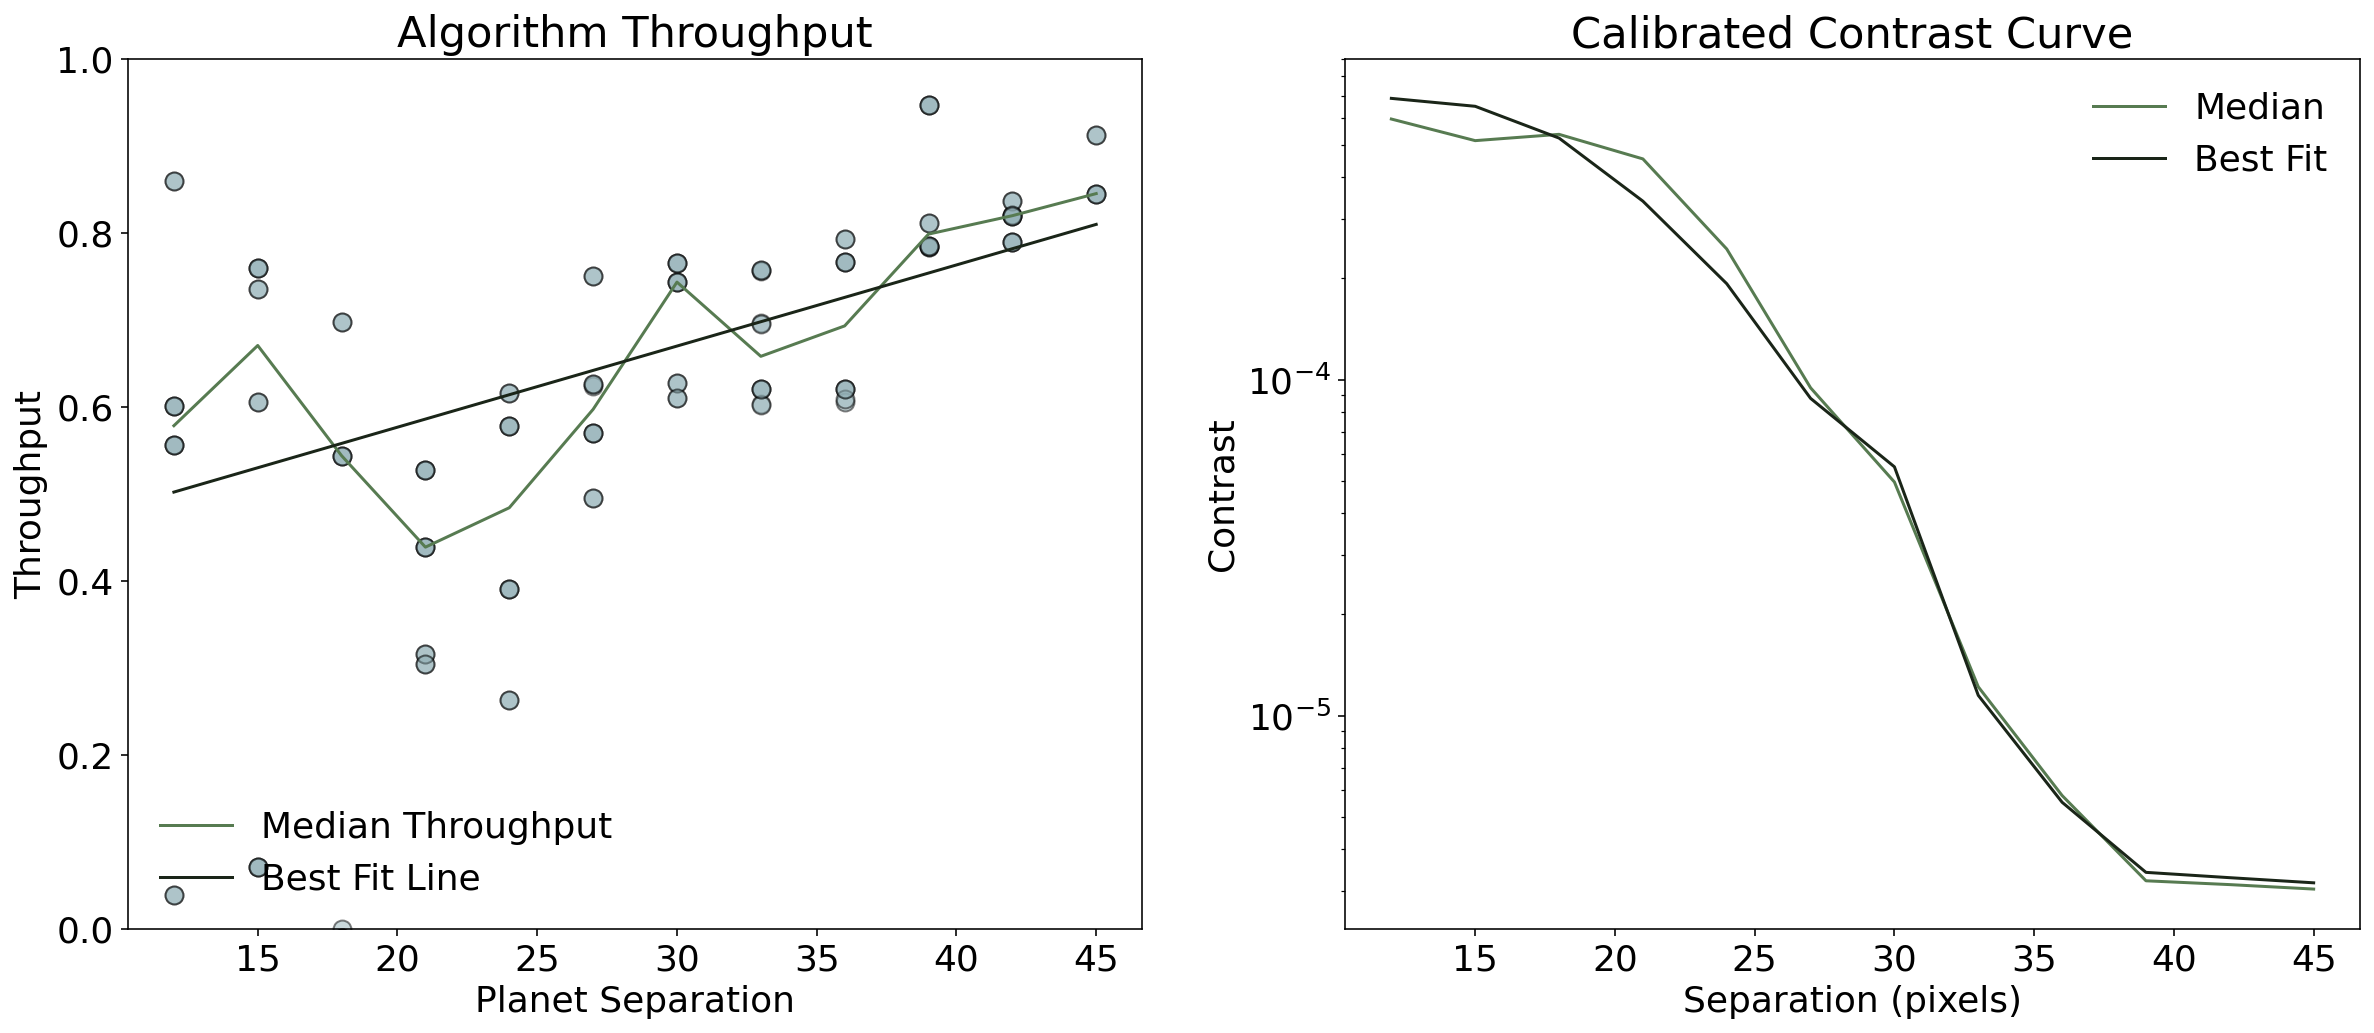

In [37]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(med_flux_sep["separation"], med_flux_sep["throughput"], color="#577B51", label="Median Throughput")
ax1.scatter(flux_sep["separation"], flux_sep["throughput"], color = '#95B2B8', alpha=0.5, edgecolors='black', s = 80)
ax1.plot(med_flux_sep['separation'], y, label = "Best Fit Line", color = "#1A2518")
plt.ylim(0,1)
plt.ylabel("Throughput")
plt.xlabel("Planet Separation")
plt.title("Algorithm Throughput")
plt.legend(frameon=False, loc="lower left")

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(med_flux_sep["separation"], med_flux_sep["corrected_contrast"], color = '#577B51', label = "Median")
ax2.plot(med_flux_sep["separation"], contrast_bestfit, label = 'Best Fit', color = "#1A2518")
plt.ylabel("Contrast")
plt.legend(frameon = False)
plt.xlabel("Separation (pixels)")
plt.title('Calibrated Contrast Curve')
plt.yscale("log")

### Now we can compare how much we've improved our contrast measurements

Text(0.5, 0, 'Separation (pixels)')

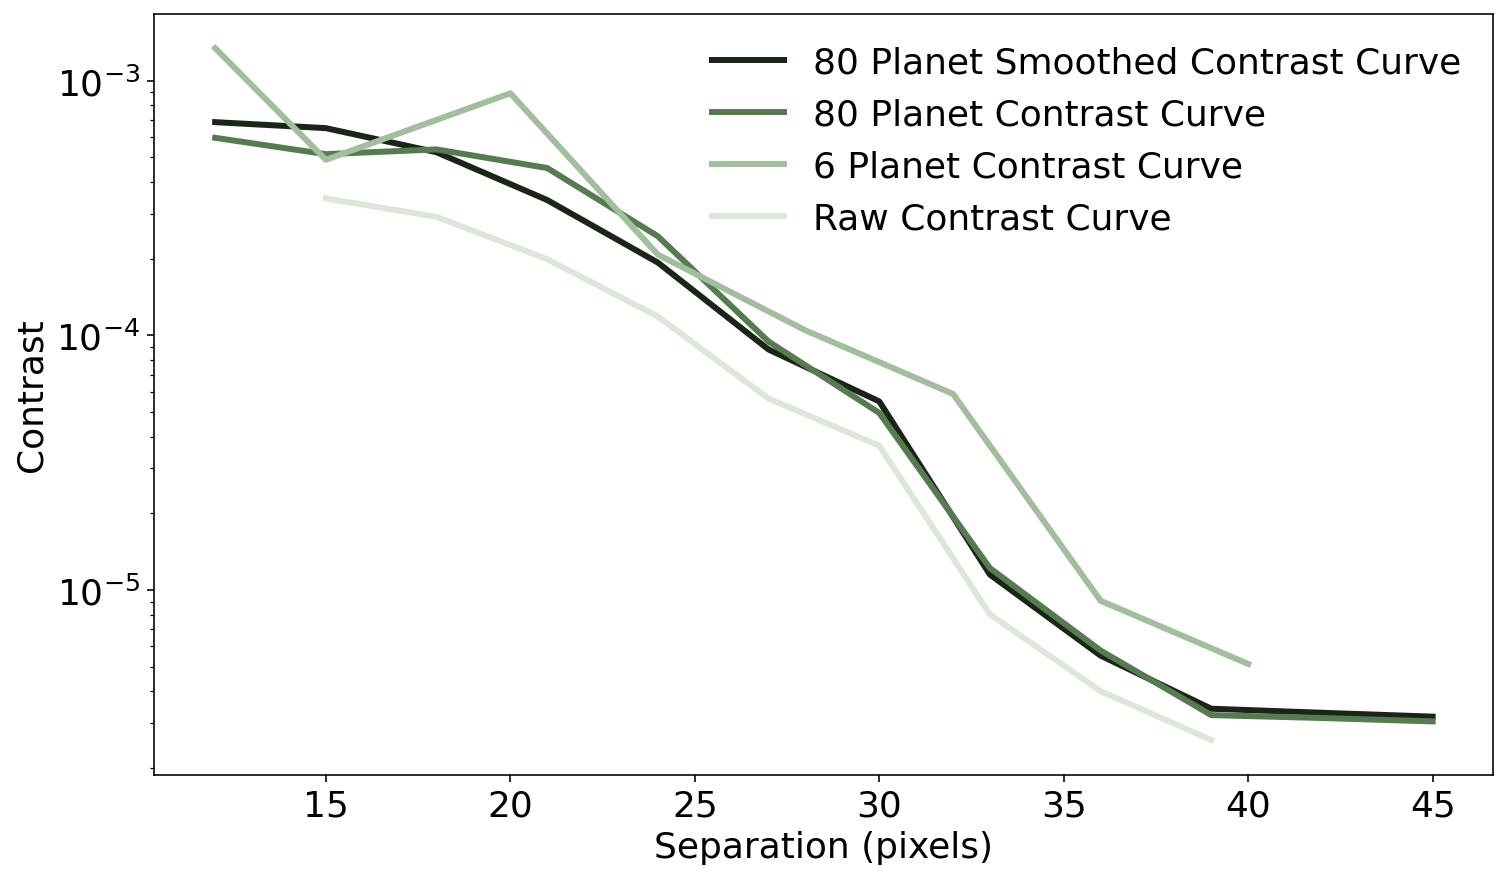

In [36]:
plt.figure(figsize=(12,7))
plt.plot(med_flux_sep["separation"], contrast_bestfit, label = '80 Planet Smoothed Contrast Curve', linewidth = 3, color = '#1A2518')
plt.plot(med_flux_sep["separation"], med_flux_sep["corrected_contrast"], color="#577B51", linewidth = 3, label = '80 Planet Contrast Curve')
plt.plot(planet_seps, corrected_contrast, color="#A1BF9C", linewidth = 3, label = '6 Planet Contrast Curve')
plt.plot(contrast_seps, norm_contrast, color="#DCE7DA", linewidth = 3, label = 'Raw Contrast Curve')
plt.legend(frameon = False)
plt.yscale('log')
plt.ylabel("Contrast")
plt.xlabel("Separation (pixels)")